In [1]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

In [2]:
 import RSI

In [3]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [4]:
data=pd.read_csv("MASI.csv",parse_dates=True, index_col=0)

In [5]:
data

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2018-01-02,12388.82,12442.75,12372.18,12420.15,0,MAD
2018-01-03,12420.15,12510.45,12380.18,12509.58,0,MAD
2018-01-04,12509.58,12543.53,12434.17,12463.08,0,MAD
2018-01-05,12463.08,12538.65,12430.09,12537.75,0,MAD
2018-01-08,12537.75,12568.29,12462.70,12479.42,0,MAD
...,...,...,...,...,...,...
2022-03-28,12602.92,12640.22,12590.87,12640.22,0,MAD
2022-03-29,12640.22,12721.38,12625.64,12721.38,0,MAD
2022-03-30,12721.38,12782.51,12703.18,12751.45,0,MAD


In [6]:
df=data["Close"].loc["2018-01-02":]
high=data["High"].loc["2018-01-02":]
low=data["Low"].loc["2018-01-02":]


## Fonction

In [7]:
premier=0 

In [8]:
def GeneticAlgo(dim,obj_func,MAX_GENERATIONS,BOUND_LOW,BOUND_UP,POPULATION_SIZE=40,P_CROSSOVER = 0.9,P_MUTATION = 0.1):
	global premier
	ONE_MAX_LENGTH=dim
	HALL_OF_FAME_SIZE = 5
	CROWDING_FACTOR=20
	RANDOM_SEED = 40
	random.seed(RANDOM_SEED)
	if premier> 0 :
		del creator.FitnessMax
		del creator.Individual
	premier=premier+1
	toolbox = base.Toolbox()
	toolbox.register("Num", random.randint, BOUND_LOW, BOUND_UP)
	creator.create("FitnessMax", base.Fitness, weights=(1.0,))
	creator.create("Individual", list, fitness=creator.FitnessMax)
	toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.Num, ONE_MAX_LENGTH)
	toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)
	toolbox.register("evaluate", obj_func)
	toolbox.register("select", tools.selTournament, tournsize=3)
	toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR)
	toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR, indpb=0.20)
	def main():
		population = toolbox.populationCreator(n=POPULATION_SIZE)
		stats = tools.Statistics(lambda ind: ind.fitness.values)
		stats.register("max", np.max)
		stats.register("avg", np.mean)
		hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
		population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,ngen=MAX_GENERATIONS
			, stats=stats, halloffame=hof, verbose=True)
		print("Hall of Fame Individuals = ", *hof.items, sep="\n")
		print("Best Ever Individual = ", [ int(i) for i in hof.items[0]])
		maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")
		sns.set_style("whitegrid")
		plt.plot(maxFitnessValues, color='red')
		plt.plot(meanFitnessValues, color='green')
		plt.xlabel('Génération')
		plt.ylabel('Max / Moyenne Fitness')
		plt.title('Max et Moyenne de  Fitness opar générations')
		plt.show()
	main()

In [9]:
# Coût des transactions
ti=0.0022
fr=0.0011
cb=0.0011
taux=ti+fr+cb

## **TEST macd**

In [20]:
from RSI import RelativeStrengthIndex

In [15]:
n=12

In [21]:
rsi=RelativeStrengthIndex(input_data=data,period=n)

In [22]:
rsi

In [24]:
rsi._calculateTi(period=16)["rsi"]

Date
2018-01-02        NaN
2018-01-03        NaN
2018-01-04        NaN
2018-01-05        NaN
2018-01-08        NaN
               ...   
2022-03-28    39.2274
2022-03-29    43.5567
2022-03-30    45.1364
2022-03-31    48.6144
2022-04-01    49.9342
Name: rsi, Length: 1056, dtype: float64

In [12]:
def pmv(close,signal):
	"""
		La Plus-ou-moins-value
	"""
	close=np.array(close)
	signal=np.array(signal.fillna(0))
	qt=signal.cumsum()
	achat= np.where(signal>=1,1,0)
	PDR=[]
	for t in range(len(close)):
		p=(close[:t+1]*achat[:t+1]).sum()
		if achat[:t+1].sum()==0 :
			val=0
		else :
			p=p/(achat[:t+1].sum())
			val=qt[t]*p 
		PDR.append(val)
	PMV_lat=close*qt-PDR
	PMV_re=[0]
	for i in range(1,len(close)):
		vl=PDR[i]-PDR[i-1]+PMV_re[i-1]-close[i]*signal[i]
		PMV_re.append(vl)
	PMV=PMV_lat+PMV_re
	return PMV

In [13]:
def adjustsignal(signal):
	sig=[]
	qtite=0
	for i in signal:
		if i > 0 :
			sig.append(i)
			qtite+=1
		elif i < 0:
			if qtite >= abs(i) :
				sig.append(i)
				qtite+=-i
			else:
				sig.append(0)
		else:
			sig.append(0)
	return sig

## RSI

In [31]:
def  obj_rsi(period):
    global haut
    global bas
    period=int(period[0])
    signal=pd.DataFrame(index=df.index)
    rs=rsi._calculateTi(period)["rsi"]
#rs=at.rsi(df,n)["RSI"]
    signal["compa_achat"]=np.nan
    signal["compa_vente"]=np.nan
    signal["compa_achat"][period:]=np.where(rs[period:] > bas,1,0)
    signal["signal_achat"]=signal["compa_achat"].diff()
    signal["compa_vente"][period:]=np.where(rs[period:] < haut,4,2)
    signal["signal_vente"]=signal["compa_vente"].diff()
    sig=np.where(signal["signal_achat"]==1,1,0)+np.where(signal["signal_vente"]==2,-1,0)
    sig=adjustsignal(sig)
    sig=pd.Series(sig, index=df.index)
    cours=df*(1+taux*sig)
    pmval=pmv(cours,sig)
    return pmval.max(),

gen	nevals	max	avg
0  	40    	0  	0  
1  	32    	0  	0  
2  	38    	0  	0  
3  	35    	0  	0  
4  	38    	0  	0  
5  	36    	0  	0  
Hall of Fame Individuals = 
[22]
[20]
[14]
[29]
[27]
Best Ever Individual =  [22]


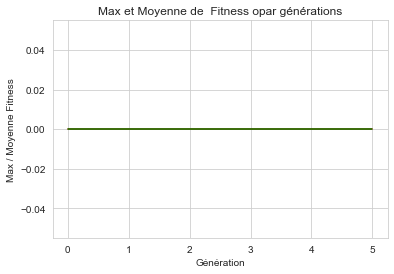

In [32]:
haut,bas=0.7,0.3
GeneticAlgo(1,obj_rsi,5,13,30)

gen	nevals	max	avg
0  	40    	0  	0  
1  	32    	0  	0  
2  	38    	0  	0  
3  	35    	0  	0  
4  	38    	0  	0  
5  	36    	0  	0  
Hall of Fame Individuals = 
[22]
[20]
[14]
[29]
[27]
Best Ever Individual =  [22]


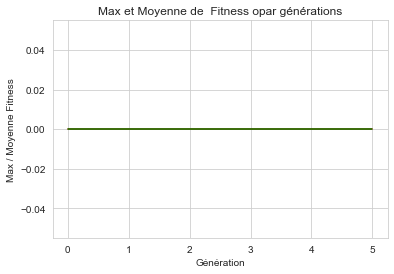

In [33]:
haut,bas=0.75,0.25
GeneticAlgo(1,obj_rsi,5,13,30)


gen	nevals	max	avg
0  	40    	0  	0  
1  	32    	0  	0  
2  	38    	0  	0  
3  	35    	0  	0  
4  	38    	0  	0  
5  	36    	0  	0  
Hall of Fame Individuals = 
[22]
[20]
[14]
[29]
[27]
Best Ever Individual =  [22]


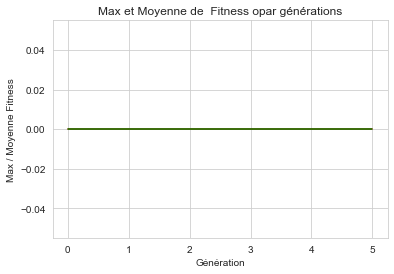

In [34]:
haut,bas=0.8,0.20
GeneticAlgo(1,obj_rsi,5,13,30)

gen	nevals	max	avg
0  	40    	0  	0  
1  	32    	0  	0  
2  	38    	0  	0  
3  	35    	0  	0  
4  	38    	0  	0  
5  	36    	0  	0  
6  	35    	0  	0  
Hall of Fame Individuals = 
[22]
[20]
[14]
[29]
[27]
Best Ever Individual =  [22]


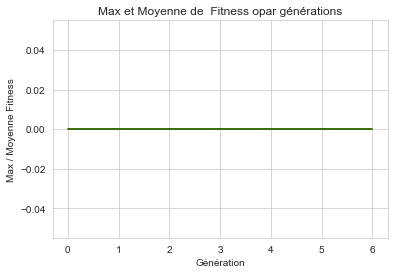

In [35]:
haut,bas=0.85,0.15
GeneticAlgo(1,obj_rsi,6,13,30)

gen	nevals	max	avg
0  	40    	0  	0  
1  	32    	0  	0  
2  	38    	0  	0  
3  	35    	0  	0  
4  	38    	0  	0  
5  	36    	0  	0  
6  	35    	0  	0  
Hall of Fame Individuals = 
[22]
[20]
[14]
[29]
[27]
Best Ever Individual =  [22]


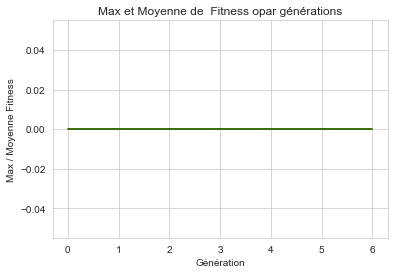

In [36]:
haut,bas=0.9,0.1
GeneticAlgo(1,obj_rsi,6,13,30)

## Stochastique 1 

In [38]:
df1=data["COURS_CLOTURE"].loc["2008-01-01":]
high1=data["COURS_PLUS_HAUT"].loc["2008-01-01":]
low1=data["COURS_PLUS_BAS"].loc["2008-01-01":]
vol1=data["Volume_Marche_Bloc"].loc["2008-01-01":] + data["Volume_Marche_Central"].loc["2008-01-01":]

In [39]:
def obj_stochastique1(n):
	global haut
	global bas
	n=int(n[0])
	signal=pd.DataFrame(index=df1.index)
	k=at.stochastique(df1 ,high1,low1, n , 3)["%K"]
	signal["compa_achat"]=np.nan
	signal["compa_vente"]=np.nan
	signal["compa_achat"][n:]=np.where(k[n:] > bas,1,0)
	signal["signal_achat"]=signal["compa_achat"].diff()
	signal["compa_vente"][n:]=np.where(k[n:] < haut,4,2)
	signal["signal_vente"]=signal["compa_vente"].diff()
	sig=np.where(signal["signal_achat"]==1,1,0)+np.where(signal["signal_vente"]==2,-1,0)
	sig=at.adjustsignal(sig)
	sig=pd.Series(sig, index=df1.index)
	cours=df1*(1+taux*sig)
	pmval=at.pmv(cours,sig)
	return pmval.max(),

gen	nevals	max    	avg    
0  	40    	99793.7	53686.5
1  	36    	99793.7	73209.4
2  	37    	99793.7	94390.9
3  	37    	99793.7	97748.4
4  	40    	99793.7	99442.5
5  	38    	99793.7	98740.2
6  	35    	99793.7	97385.3
7  	35    	99793.7	99357.7
8  	39    	99793.7	97829  
9  	36    	99793.7	98389  
10 	31    	99793.7	99793.7
Hall of Fame Individuals = 
[17.919334156751997]
[17.96685189632885]
[17.9978682618566]
[17.988601798793958]
[17]
Best Ever Individual =  [17]


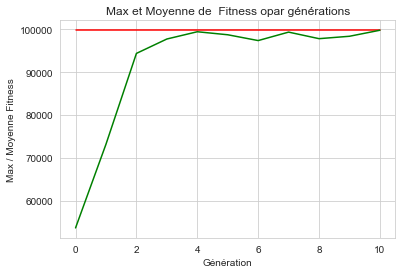

In [40]:
haut,bas=70,30
GeneticAlgo(1,obj_stochastique1,10,12,30)

gen	nevals	max   	avg    
0  	40    	106423	72012.8
1  	36    	106423	95141.1
2  	36    	106423	101849 
3  	38    	106423	104020 
4  	38    	106423	105545 
5  	36    	106423	105979 
6  	35    	106423	105920 
Hall of Fame Individuals = 
[19.77959592459486]
[19.928022220991803]
[19.07007538924168]
[19.06966466799333]
[19]
Best Ever Individual =  [19]


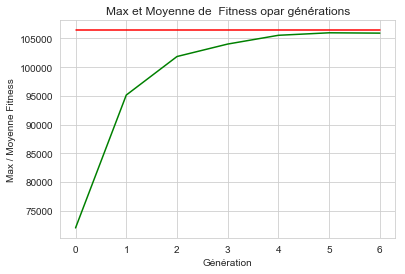

In [41]:
haut,bas=75,25
GeneticAlgo(1,obj_stochastique1,6,12,30)

gen	nevals	max   	avg    
0  	40    	122461	90004.4
1  	36    	122955	107308 
2  	36    	118507	113912 
3  	38    	122955	118442 
4  	38    	122955	119260 
5  	36    	122955	121065 
6  	35    	122955	122286 
Hall of Fame Individuals = 
[24.972246185419596]
[24.99663949204258]
[24.97401222030901]
[24.97016478622455]
[24.982902698190937]
Best Ever Individual =  [24]


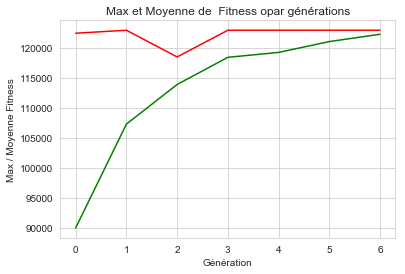

In [42]:
haut,bas=80,20
GeneticAlgo(1,obj_stochastique1,6,12,30)

gen	nevals	max   	avg    
0  	40    	104616	55052.2
1  	36    	122796	80549.4
2  	36    	122796	98457.8
3  	38    	122796	107055 
4  	40    	122796	117796 
5  	36    	122796	121887 
6  	34    	122796	122796 
Hall of Fame Individuals = 
[29.97749315774866]
[29.924469964069907]
[29.93203783236319]
[29.955043778423793]
[29.972881863644258]
Best Ever Individual =  [29]


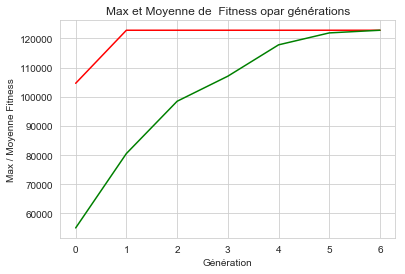

In [43]:
haut,bas=85,15
GeneticAlgo(1,obj_stochastique1,6,12,30)

gen	nevals	max    	avg    
0  	40    	85015.5	49726.7
1  	36    	85015.5	68298  
2  	36    	85015.5	78605.4
3  	39    	85015.5	81681.8
4  	38    	85015.5	82052.8
5  	35    	85015.5	83369.5
6  	37    	85015.5	84550.9
Hall of Fame Individuals = 
[30]
[25.973595621473944]
[25.954407150280392]
[25.204142596504358]
[25]
Best Ever Individual =  [30]


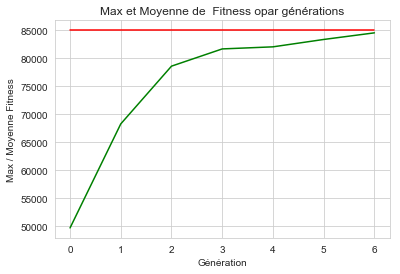

In [44]:
haut,bas=90,10
GeneticAlgo(1,obj_stochastique1,6,12,30)

## Stochastique 2

In [45]:
def obj_stochastique2(n ):
	n.sort()
	w=int(n[0])
	n=int(n[1])
	signal=pd.DataFrame(index=df1.index)
	k=at.stochastique(df1 ,high1,low1, n , w)[["%K","%D"]]
	signal["compa"]=np.nan
	signal["compa"][n+w :]=np.where(k["%K"][n+w:] > k["%D"][n+w:],1,0)
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df1*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

gen	nevals	max    	avg    
0  	40    	363.536	148.409
1  	36    	363.536	191.662
2  	40    	363.536	219.29 
3  	38    	363.536	265.516
4  	34    	363.536	291.195
5  	37    	363.536	339.643
6  	38    	363.536	349.87 
Hall of Fame Individuals = 
[9.064345322627561, 27]
[7, 27.007042272250434]
[7, 27.002199996772518]
[9.021856188829561, 26.010846767370175]
[7, 27]
Best Ever Individual =  [9, 27]


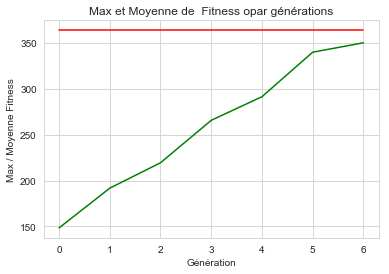

In [46]:
GeneticAlgo(2,obj_stochastique2,6,3,30)

## OBV

In [47]:
def obj_obv(n):
	n=int(n[0])
	signal=pd.DataFrame(index=df.index)
	ob=at.obv(df,vol)["OBV"]
	obs=pd.Series(ob.rolling(n).mean(), name='obvsignal')
	signal["compa"]=np.nan 
	signal["compa"][n:]=np.where( ob[n:]  > obs[n:],1,0)
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

gen	nevals	max   	avg    
0  	40    	5710.3	3323.86
1  	35    	5710.3	4130.23
2  	38    	5710.3	4701.1 
3  	36    	5710.3	4946.22
4  	40    	5710.3	5342.56
5  	36    	5710.3	5381.72
6  	35    	5710.3	5453.75
Hall of Fame Individuals = 
[32.00117617118097]
[32]
[30.03476200420938]
[10.489186803722037]
[10.105610197964031]
Best Ever Individual =  [32]


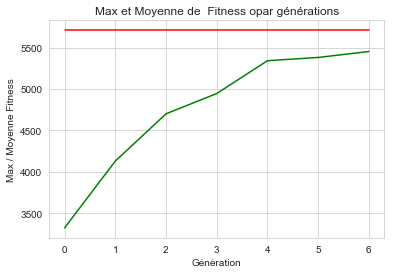

In [48]:
GeneticAlgo(1,obj_obv,6,10,100)

## ROC

In [49]:
def obj_roc(n):
	w=int(n[0])
	signal=pd.DataFrame(index=df.index)
	roc=at.rate_of_change(df,w)["ROC"]
	signal["compa"]=np.nan
	signal["compa"][w:]=np.where( roc[w:]> 0,1,0)
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

gen	nevals	max    	avg    
0  	40    	9247.61	8680.78
1  	36    	9247.61	8928.54
2  	36    	9817.07	9185.35
3  	38    	9817.07	9278.41
4  	40    	9817.07	9371.07
5  	35    	9817.07	9482.12
6  	35    	9817.07	9681.22
7  	32    	9817.07	9817.07
8  	38    	9817.07	9796.83
9  	36    	9817.07	9817.07
10 	32    	9817.07	9817.07
Hall of Fame Individuals = 
[12.859059653692416]
[12.831747108423938]
[12.810449754080768]
[12.783243796171122]
[12.960617592581624]
Best Ever Individual =  [12]


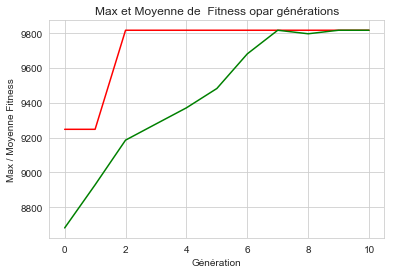

In [50]:
GeneticAlgo(1,obj_roc,10,10,30)

## MFI

In [51]:
def obj_mfi(n):
	global haut
	global bas
	n=int(n[0])
	signal=pd.DataFrame(index=df1.index)
	mfi=at.MFI(df1,vol1,high1,low1,n)['MFI']
	signal["compa_achat"]=np.nan
	signal["compa_vente"]=np.nan
	signal["compa_achat"][n:]=np.where(mfi[n:] > bas,1,0)
	signal["signal_achat"]=signal["compa_achat"].diff()
	signal["compa_vente"][n:]=np.where(mfi[n:] < haut,4,2)
	signal["signal_vente"]=signal["compa_vente"].diff()
	sig=np.where(signal["signal_achat"]==1,1,0)+np.where(signal["signal_vente"]==2,-1,0)
	sig=at.adjustsignal(sig)
	sig=pd.Series(sig, index=df1.index)
	cours=df1*(1+taux*sig)
	pmval=at.pmv(cours,sig)
	return pmval.max(),

gen	nevals	max    	avg    
0  	40    	42020.2	14632.1
1  	38    	42020.2	21588.2
2  	38    	42020.2	29387.1
3  	38    	42020.2	37138.1
4  	38    	42020.2	41746  
5  	36    	42020.2	41746  
6  	35    	42020.2	42020.2
Hall of Fame Individuals = 
[10.31796827195453]
[10.049935500799986]
[10.965167666003335]
[10.318712013241512]
[10]
Best Ever Individual =  [10]


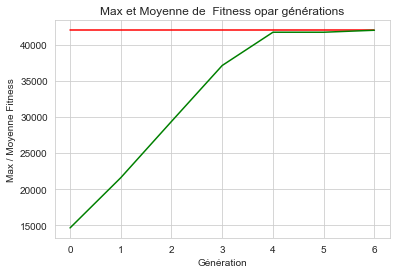

In [52]:
haut,bas=80,20
GeneticAlgo(1,obj_mfi,6,10,30)

gen	nevals	max    	avg    
0  	40    	45035.1	23226.1
1  	36    	45035.1	34671.9
2  	36    	45035.1	40334.8
3  	38    	45035.1	42473.1
4  	38    	45035.1	41625  
5  	36    	45035.1	43330  
6  	35    	45035.1	43898.4
Hall of Fame Individuals = 
[20.669853613610556]
[20.021899954263507]
[20.03419460361813]
[20.63510010855244]
[20]
Best Ever Individual =  [20]


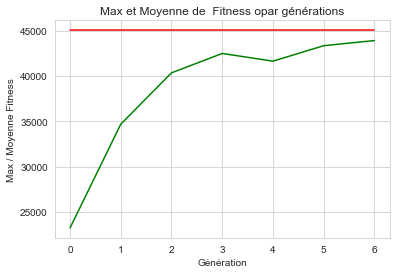

In [53]:
haut,bas=70,30
GeneticAlgo(1,obj_mfi,6,10,30)

## CHO

In [54]:
def obj_cho(ind):
	ind.sort()
	ws=int(ind[0])
	wl=int(ind[1])
	n=int(ind[2])
	signal=pd.DataFrame(index=df1.index)
	signal["compa"]=np.nan 
	ch=at.cho(df1,vol1,high1,low1,n,ws,wl)["CHO"]
	signal["compa"][ws+wl:]=np.where(ch[ws+wl:] > 0, 1,0)
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df1*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

gen	nevals	max   	avg    
0  	40    	427.83	138.501
1  	40    	521.113	179.623
2  	38    	521.113	251.153
3  	38    	521.113	259.294
4  	36    	521.113	327.132
5  	37    	521.113	456.39 
6  	36    	521.113	488.085
7  	40    	521.113	518.789
8  	36    	521.113	510.941
9  	40    	521.113	510.941
10 	40    	521.113	521.113
Hall of Fame Individuals = 
[3.697884543239409, 9.88122522392246, 11.639395050203452]
[6.889964002954178, 10, 11.649355217053241]
[3.5248337040231235, 11.520422679351134, 11.639395050203452]
[3.9298560563387746, 10.06838933817701, 11.555092248523275]
[3.5248337040231235, 10.179838940541956, 11.639395050203452]
Best Ever Individual =  [3, 9, 11]


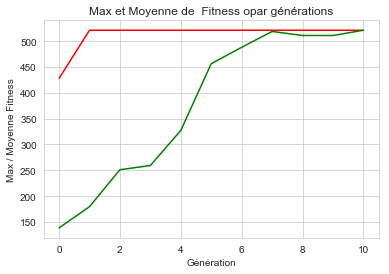

In [55]:
GeneticAlgo(3,obj_cho,10,3,30)

## NVI

In [56]:
def obj_nvi(n):
	n=int(n[0])
	signal=pd.DataFrame(index=df.index)
	signal["compa"]=np.nan 
	nv=at.nvi(df,vol)
	nvis=pd.Series(nv.rolling(n).mean(), name="NVIsignal")
	signal["compa"][n:]=np.where(nv[n:] > nvis[n:] ,1,0)
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

gen	nevals	max    	avg    
0  	40    	168.877	5.76396
1  	36    	168.877	16.8261
2  	38    	168.877	45.0354
3  	36    	168.877	92.1703
4  	36    	168.877	138.269
5  	38    	168.877	154.463
Hall of Fame Individuals = 
[49.58139613221198]
[49.01842052128876]
[49.26650626329102]
[49.711099704172426]
[49]
Best Ever Individual =  [49]


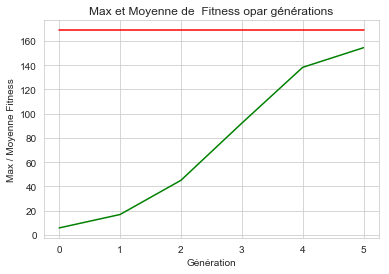

In [64]:
GeneticAlgo(1,obj_nvi,5,8,50)

## PVI

In [58]:
def obj_pvi(n):
	n=int(n[0])
	signal=pd.DataFrame(index=df.index)
	signal["compa"]=np.nan 
	pv=at.pvi(df,vol)
	pvis=pd.Series(pv.rolling(n).mean(), name="NVIsignal")
	signal["compa"][n:]=np.where(pv[n:] > pvis[n:] ,1,0)
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

gen	nevals	max    	avg    
0  	40    	144.149	7.25749
1  	36    	144.149	3.66377
2  	38    	144.149	3.74384
3  	37    	0.40034	0.300255
4  	38    	0.40034	0.390331
5  	38    	0.40034	0.40034 
Hall of Fame Individuals = 
[50]
[10.074612506915397]
[11]
[9]
[10]
Best Ever Individual =  [50]


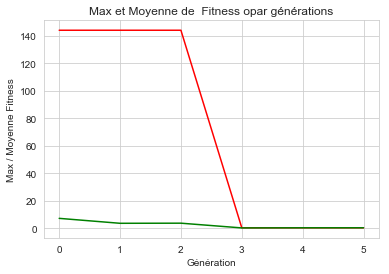

In [65]:
GeneticAlgo(1,obj_pvi,5,8,50)

In [60]:
## Momentum 

In [61]:
def obj_momentum(n):
	w=int(n[0])
	MOM=at.momentum(df,w,wsig=9)[["MOM","MOMsignal"]]
	signal=pd.DataFrame(index=df.index)
	signal["compa"]=np.nan
	signal["compa"][w:]=np.where(MOM["MOM"][w:] > MOM["MOMsignal"][w:],1,0)
	signal["signal"]=at.adjustsignal(signal["compa"].diff())
	cours=df*(1+taux*signal["signal"])
	pmval=at.pmv(cours,signal["signal"])
	return pmval.max(),

gen	nevals	max    	avg    
0  	40    	6582.17	5225.14
1  	35    	7189.18	5654.06
2  	38    	6582.17	6145.07
3  	38    	6582.17	6398.93
4  	40    	6582.17	6418.59
5  	33    	6582.17	6489.82
Hall of Fame Individuals = 
[20.966994526842427]
[30]
[17.987485740420823]
[17.985773578769837]
[17]
Best Ever Individual =  [20]


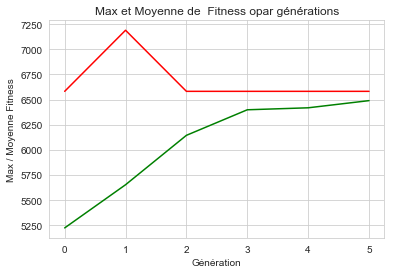

In [62]:
GeneticAlgo(1,obj_momentum,5,8,30)